<a href="https://colab.research.google.com/github/The-Algorist/Automatic_bank_cheques_data_extraction/blob/main/Recommendation_Systems_Learner_Notebook_Low_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

### **Please read the instructions carefully before starting the project.**

This is a commented Jupyter IPython Notebook file in which all the instructions and tasks to be performed are mentioned. Read along carefully to complete the project.

* Blanks '_______' are provided in the notebook that needs to be filled with an appropriate code to get the correct result. Please replace the blank with the right code snippet. With every '_______' blank, there is a comment that briefly describes what needs to be filled in the blank space.
* Identify the task to be performed correctly, and only then proceed to write the required code.
* Fill the code wherever asked by the commented lines like "# Fill in the blank" or "# Complete the code". Running incomplete code may throw an error.
* Remove the blank and state your observations in detail wherever the mark down says 'Write your observations here:_________'
* Please run the codes in a sequential manner from the beginning to avoid any unnecessary errors.
* You can the results/observations derived from the analysis here and use them to create your final report.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

**Installing surprise library**

In [2]:
!pip install surprise
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162991 sha256=224541e42d88b0d5a3cb9e61c001ea891854ede49578b9c57eca3746b1d11592
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [4]:
!chmod 600 ~/.kaggle/kaggle.json


In [8]:
!kaggle datasets download -d saurav9786/amazon-product-reviews


 96% 105M/109M [00:01<00:00, 91.3MB/s] 
100% 109M/109M [00:01<00:00, 82.3MB/s]


In [9]:
!unzip amazon-product-reviews.zip


Archive:  amazon-product-reviews.zip
  inflating: ratings_Electronics (1).csv  


## **Importing the necessary libraries and overview of the dataset**

In [10]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

### **Loading the data**

In [11]:
# Import the dataset
df = pd.read_csv('/content/ratings_Electronics (1).csv', header = None) # There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] # Adding column names

print(df.shape)

df = df.drop('timestamp', axis = 1) # Dropping timestamp

df_copy = df.copy(deep = True) # Copying the data to another DataFrame

(7824482, 4)


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [12]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [13]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [14]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [15]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [16]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

In [17]:
# Check the number of rows and columns and provide observations
rows, columns = df_final.shape
print("No of rows: ", rows)
print("No of columns: ", columns)

No of rows:  65290
No of columns:  3


**Write your observations here:______**

### **Data types**

In [18]:
# Check Data types and provide observations
df_final.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

**Write your observations here:______**

### **Checking for missing values**

In [19]:
# Check for missing values present and provide observations
# Check for missing values
missing_values = df_final.isnull().sum()

print("Missing values:")
print(missing_values)

# Provide observations
total_missing = missing_values.sum()
total_entries = df_final.shape[0] * df_final.shape[1]

print("\nObservations:")
if total_missing == 0:
    print("There are no missing values in the dataset.")
else:
    print(f"There are {total_missing} missing values out of {total_entries} total entries.")
    print("You might need to handle these missing values before proceeding with your analysis.")

Missing values:
user_id    0
prod_id    0
rating     0
dtype: int64

Observations:
There are no missing values in the dataset.


**Write your observations here:______**

### **Summary Statistics**

In [20]:
# Summary statistics of 'rating' variable and provide observations

rating_summary = df_final['rating'].describe()

print("Summary statistics of 'rating' variable:")
print(rating_summary)

Summary statistics of 'rating' variable:
count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64


**Write your observations here:______**

### **Checking the rating distribution**

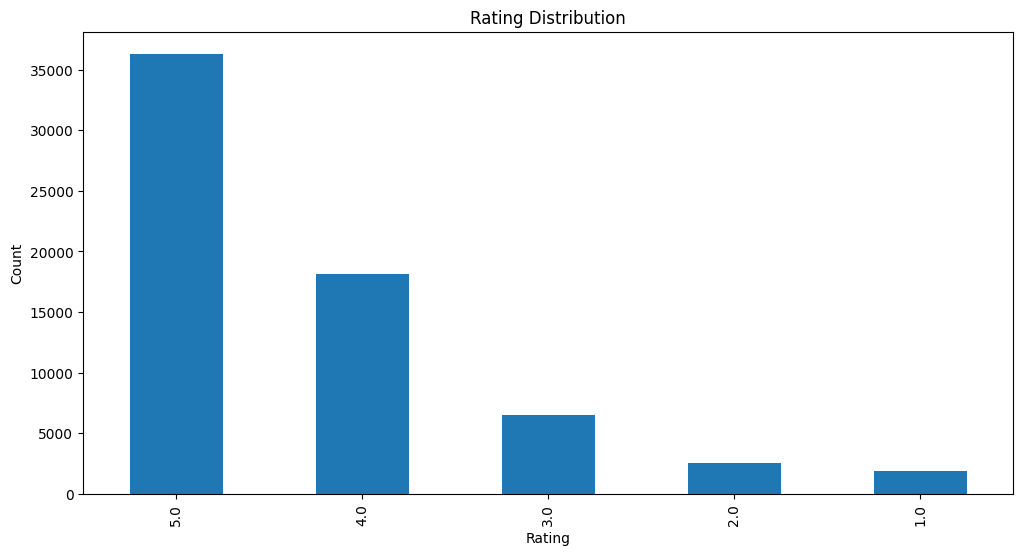

In [21]:
# Create the bar plot and provide observations
plt.figure(figsize=(12, 6))

# Fill in the blanks to create the bar plot

df_final['rating'].value_counts().plot(kind='bar')

plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.show()

**Write your observations here:________**

### **Checking the number of unique users and items in the dataset**

In [22]:
# Number of total rows in the data and number of unique user id and product id in the data

print('The number of observations in the final data = ', len(df_final))
print('Number of unique USERS in Raw data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df_final['prod_id'].nunique())

The number of observations in the final data =  65290
Number of unique USERS in Raw data =  1540
Number of unique ITEMS in Raw data =  5689


**Write your observations here:________**

### **Users with the most number of ratings**

In [23]:
# Top 10 users based on the number of ratings
# Group the data by user ID, count the number of ratings for each user, and sort in descending order
most_rated = df_final.groupby('user_id').size().sort_values(ascending=False)[:10]

# Display the top 10 users based on the number of ratings
print("Top 10 users based on the number of ratings:")
print(most_rated)

Top 10 users based on the number of ratings:
user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64


- The highest number of **ratings by a user is 295** which is far from the actual number of products present in the data. We can build a recommendation system to recommend products to users which they have not interacted with.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [24]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


### Steps:

- **Create the final_rating DataFrame**
- **Complete the code to create the function top_n_products**
- **Recommending top 5 products with 50 minimum interactions based on popularity**
- **Recommending top 5 products with 100 minimum interactions based on popularity**

In [25]:
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()

# Create a DataFrame with calculated average and count of ratings
final_rating = pd.DataFrame({'average_rating': average_rating, 'rating_count': count_rating})

# Sort the dataframe by average of ratings in descending order
final_rating = final_rating.sort_values(by='average_rating', ascending=False)

# See the first five records of the "final_rating" dataset
final_rating.head()


,average_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [26]:
def top_n_products(final_rating, n, min_interaction):

    # Finding products with minimum number of interactions
    min_interaction_products = final_rating[final_rating['rating_count'] >= min_interaction]

    # Sorting values with respect to average rating
    recommendations = min_interaction_products.sort_values(by='average_rating', ascending=False)

    return recommendations.index[:n]


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [27]:
# Call the top_n_products function with final_rating DataFrame, n=5, and min_interaction=50
top_products = top_n_products(final_rating, n=5, min_interaction=50)

# Display the recommended top products
print("Top 5 products with at least 50 interactions based on popularity:")
print(top_products)


Top 5 products with at least 50 interactions based on popularity:
Index(['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW'], dtype='object', name='prod_id')


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [28]:
# Call the top_n_products function with final_rating DataFrame, n=5, and min_interaction=100
top_products = top_n_products(final_rating, n=5, min_interaction=100)

# Display the recommended top products
print("Top 5 products with at least 100 interactions based on popularity:")
print(top_products)


Top 5 products with at least 100 interactions based on popularity:
Index(['B003ES5ZUU', 'B000N99BBC', 'B002WE6D44', 'B007WTAJTO', 'B002V88HFE'], dtype='object', name='prod_id')


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

In this type of recommendation system, `we do not need any information` about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example -
<ol>
    <li><b>Ratings</b> provided by users. For example, ratings of books on goodread, movie ratings on imdb, etc.</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos.</li>
    <li><b>Use/buying</b> of a product by users. For example, buying different items on e-commerce sites.</li>
    <li><b>Reading</b> of articles by readers on various blogs.</li>
</ol>

**Types of Collaborative Filtering**

- Similarity/Neighborhood based

 * User-User Similarity Based  
 * Item-Item similarity based

- Model based

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [29]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [30]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [31]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [32]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

- **Initialize the KNNBasic model using sim_options provided, Verbose=False, and setting random_state=1**

- **Fit the model on the training data**

- **Use the precision_recall_at_k function to calculate the metrics on the test data**

- **Provide your observations on the output**

In [33]:
# Declaring the similarity options
sim_options = {'name': 'cosine', 'user_based': True}

# Initialize the KNNBasic model
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Compute precision@k, recall@k, and f_1 score
precision_recall_at_k(sim_user_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


**Write your observations here:__________**

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5 which is denoted by the parameter r_ui.

In [34]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

**Write your observations here:__________**

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [35]:
df_final[df_final.prod_id != "1400501466"].user_id.unique()

array(['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [36]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:__________**

### **Improving Similarity-based Recommendation System by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [37]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30, 40], 'sim_options': {'name': ['cosine', 'msd', 'pearson', 'pearson_baseline']}}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


1.0359739931535321
{'k': 30, 'sim_options': {'name': 'pearson', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters** as shown above.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [38]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'pearson'}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options, k=30, min_k=1, random_state=1, verbose=False)

# Training the algorithm on the train set
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k=10
precision_recall_at_k(sim_user_user_optimized)



RMSE: 1.0363
Precision:  0.847
Recall:  0.878
F_1 score:  0.862


**Write your observations here:**____________

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [39]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
# Define the user and product IDs for recommendation
user_id = "A3LDPF5FMB782Z"
product_id = "1400501466"

# Predict rating for the given user and product
predicted_rating = sim_user_user_optimized.predict(user_id, product_id)

# Print the predicted rating
print("Predicted rating:", predicted_rating.est)


Predicted rating: 5


In [40]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
# Define the user and product IDs for recommendation
user_id = "A34BZM6S9L7QI4"
product_id = "1400501466"

# Predict rating for the given user and product
predicted_rating = sim_user_user_optimized.predict(user_id, product_id)

# Print the predicted rating
print("Predicted rating:", predicted_rating.est)


Predicted rating: 4.292024046561495


**Write your observations here:**____________

### **Identifying similar Users to a given User (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [41]:
# 0 is the inner id of the user
sim_user_user_optimized.get_neighbors(0, 5)

[12, 29, 60, 65, 71]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [42]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [43]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)

In [44]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B00005ATMB,5
1,B0000UV2AW,5
2,B000233WJ6,5
3,B0002YE686,5
4,B000652M6Y,5


**Write your observations here:**____________

### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [45]:
# Declaring the similarity options
sim_options = {'name': 'cosine', 'user_based': False}

# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Train the algorithm on the train set, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k=10
precision_recall_at_k(sim_item_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


**Write your observations here:**____________

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`**. Here the user has already interacted or watched the product with productId "1400501466".

In [46]:
# Define the user and product IDs for prediction
user_id = "A3LDPF5FMB782Z"
product_id = "1400501466"

# Predict rating for the given user and product
predicted_rating = sim_item_item.predict(user_id, product_id)

# Print the predicted rating
print("Predicted rating:", predicted_rating.est)

Predicted rating: 4.2727272727272725


**Write your observations here:**____________

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [47]:
# Define the user and product IDs for prediction
user_id = "A34BZM6S9L7QI4"
product_id = "1400501466"

# Predict rating for the given user and product
predicted_rating = sim_item_item.predict(user_id, product_id)

# Print the predicted rating
print("Predicted rating:", predicted_rating.est)


Predicted rating: 4.292024046561495


**Write your observations here:**____________

### **Hyperparameter tuning the item-item similarity-based model**

- Use the following values for the param_grid and tune the model
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [48]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9], 'sim_options': {'name': ['msd', 'cosine'], 'user_based': [False]}}

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

In [49]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd', 'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(k=30, min_k=9, sim_options=sim_options, random_state=1, verbose=False)

# Training the algorithm on the train set
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)


RMSE: 0.9567
Precision:  0.838
Recall:  0.889
F_1 score:  0.863


**Write your observations here:__________**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [50]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
# Define the user and product IDs for prediction
user_id_1 = "A3LDPF5FMB782Z"
product_id_1 = "1400501466"

# Predict rating for the given user and product using the optimized model
predicted_rating_1 = sim_item_item_optimized.predict(user_id_1, product_id_1)

# Print the predicted rating
print("Predicted rating for user A3LDPF5FMB782Z and product 1400501466:", predicted_rating_1.est)


Predicted rating for user A3LDPF5FMB782Z and product 1400501466: 4.67427701674277


In [51]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
# Define the user and product IDs for recommendation
user_id = "A34BZM6S9L7QI4"
product_id = "1400501466"

# Predict rating for the given user and product using the optimized model
predicted_rating = sim_item_item_optimized.predict(user_id, product_id)

# Print the predicted rating
print("Predicted rating for user A34BZM6S9L7QI4 and product 1400501466:", predicted_rating.est)


Predicted rating for user A34BZM6S9L7QI4 and product 1400501466: 4.292024046561495


**Write your observations here:__________**

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [52]:
# Find the 5 most similar items to the item with internal ID 0 based on the MSD distance metric
similar_items = sim_item_item_optimized.get_neighbors(0, k=5)

# Print the list of similar items
print("5 most similar items to item with internal ID 0:", similar_items)

5 most similar items to item with internal ID 0: [29, 53, 67, 106, 151]


**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

In [53]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [54]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


**Write your observations here:__________**

Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

## **Model 3: Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### **Singular Value Decomposition (SVD)**

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [55]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)

# Training the algorithm on the train set
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


**Write your observations here:___________**

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [56]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

**Write your observations here:___________**

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [57]:
# Making prediction
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

**Write your observations here:___________**

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [58]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01], 'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_svd.fit(data)

# Best RMSE score
print(gs_svd.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_svd.best_params['rmse'])


0.8980147656279778
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [59]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state = 1
svd_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)

# Train the algorithm on the train set
svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)


RMSE: 0.8808
Precision:  0.854
Recall:  0.878
F_1 score:  0.866


**Write your observations here:_____________**

**Let's now predict a rating for a user with `userId = "A3LDPF5FMB782Z"` and `productId = "1400501466"` with the optimized model.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [60]:
# Define the user and product IDs for prediction
user_id_1 = "A3LDPF5FMB782Z"
product_id_1 = "1400501466"

# Predict rating for the given user and product using the optimized model
predicted_rating_1 = svd_optimized.predict(user_id_1, product_id_1)

# Print the predicted rating
print("Predicted rating for user A3LDPF5FMB782Z and product 1400501466:", predicted_rating_1.est)


Predicted rating for user A3LDPF5FMB782Z and product 1400501466: 4.128589011282042


In [61]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
# Define the user and product IDs for prediction
user_id_2 = "A34BZM6S9L7QI4"
product_id_2 = "1400501466"

# Predict rating for the given user and product using the optimized model
predicted_rating_2 = svd_optimized.predict(user_id_2, product_id_2)

# Print the predicted rating
print("Predicted rating for user A34BZM6S9L7QI4 and product 1400501466:", predicted_rating_2.est)


Predicted rating for user A34BZM6S9L7QI4 and product 1400501466: 4.216280997100113


**Write your observations here:**_____________

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**